# Setting

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Parameters

In [5]:
PATH = '/content/drive/MyDrive/FIR_Project'
KEYPOINTS = 50
K = 32

In [196]:
def get_filename(saved_object,version,detector,attempt,descriptor_param = None, result_note = None):

  version_path = '_' + VERSION
  attempt_path = '-v' + str(attempt)
  
  descriptor_param_path = '-' + str(descriptor_param) if descriptor_param is not None else ''

  if saved_object == 'results':
    result_note_path = '-' + result_note if result_note is not None else ''
    return PATH + '/result_v2/' + detector + descriptor_param_path + attempt_path  + '-results'+ result_note_path + version_path + '.txt'
  else:
    former_path = PATH + '/model/' + detector + descriptor_param_path + attempt_path + '-'
    if saved_object == 'descriptors':
      return PATH + '/model/' + detector + descriptor_param_path+ '-' + 'map-descriptors' + version_path + '.bin'
    if saved_object == 'map_bows':
      return former_path + 'map_bows' + version_path + '.npy'
    if saved_object == 'centroids':
      return former_path + 'kmeans' + version_path + '.pkl'

## Import Modules

In [197]:
!pip install opencv-python==4.5.3.56
!pip install opencv-contrib-python==4.5.3.56
#!pip install opencv-python==3.4.2.17

In [9]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from skimage.color import rgb2gray
import sklearn
from sklearn import preprocessing
from skimage.feature import ORB
from skimage.feature import BRIEF
from skimage.feature import corner_harris
from skimage.feature import corner_peaks
from sklearn.cluster import KMeans
import pickle
import scipy
import cv2
from skimage import transform
from timeit import default_timer as timer
from skimage.exposure import adjust_gamma, adjust_log
from scipy import ndimage
from skimage.io import imsave

# Import Data

In [3]:
def get_map(version):
  if version == 'extended':
    path = PATH + '/data/database/database.json'
  else:
    path = PATH + '/data/database/database_lite.json'

  with open(path ,'r') as f:
    m_idx = json.load(f) 
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])
  return m_idx, m_imgs, m_loc

In [200]:
def get_query(version):
  if version == 'extendend':
    path = PATH + '/data/query/query.json'
  else:
    path = PATH + '/data/query/query_lite.json'
  with open(path,'r') as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])
  return q_idx, q_imgs, q_loc

In [201]:
def get_judgements(version):
    
    '''
    The london_lite_gt.h5 file contains two sets of relevance judgements, specified by the keys sim and fov.
    sim specifies it in the form 0/1 (non-relevant/relevant).
    fov (that stands for field of view) specifies it as a degree of similarity, a value defined in the interval [0,1] that indicates how much the query and map images are similar. 
    We do not use it for this assignment, but you may consider it when working on the final project.
    '''
    
    if version == 'extended':
        path = PATH + '/data/london_gt.h5'
    else:
        path = PATH + '/data/london_lite_gt.h5'
        
    # loading the relevance judgements
    with h5py.File(path,"r") as f:
        fovs = f["fov"][:] # 0/1 non-relevant/relevant
        sim = f["sim"][:].astype(np.uint8) # degree of similarity, range[0,1]
        
    return fovs, sim

In [202]:
def read_img(img_name, detector):
    path = PATH + '/data/'
    path = os.path.join(path, img_name)
    if detector == 'ORB' and detector == 'BRIEF':
      img = plt.imread(path)
      img = rgb2gray(img)
    else:
      img = cv2.imread(path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return img

# Descriptors

In [203]:
def get_descriptor_extractor(detector,descriptor_param):
  if detector == 'ORB':
    if descriptor_param == 'default':
      descriptor_extractor = ORB()
    else:
      descriptor_extractor = ORB(n_keypoints= KEYPOINTS)    
  if detector == 'SIFT':
    #descriptor_extractor = cv2.SIFT_create()
    descriptor_extractor = cv2.xfeatures2d.SIFT_create()
  if detector == 'SURF':
    minHessian = descriptor_param
    descriptor_extractor = cv2.SURF_create(hessianThreshold=minHessian)
  if detector == 'BRIEF':
    descriptor_extractor = BRIEF()
  return descriptor_extractor

In [204]:
def extract_descriptor(detector, img, descriptor_extractor):
  if detector == 'ORB':
    # extract the keypoints and corresponding descriptors (50 ORB descriptors)
    descriptor_extractor.detect_and_extract(img)
    descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)
  if detector == 'BRIEF':
    keypoints = corner_peaks(corner_harris(img), min_distance=5, threshold_rel=0.1)
    descriptor_extractor.extract(img,keypoints)
    descriptors_img = descriptor_extractor.descriptors
  if detector == 'SIFT':
    #img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    keypoints, descriptors = descriptor_extractor.detectAndCompute(img,None)
    descriptors_img = descriptors
  if detector == 'SURF':
    descriptors_img = None

  return descriptors_img

In [205]:
def get_map_descriptor(detector, detector_extractor, attempt, descriptor_param = None):

  path = get_filename(saved_object = 'descriptors', version=VERSION, detector=detector, descriptor_param = descriptor_param, attempt = attempt)
  
  if os.path.isfile(path):
    # if descriptor file exist
    f = open(path, 'rb')
    descriptors = pickle.load(f)
    f.close()

    return descriptors
  else:
    # if descriptor file not exist
    # create descriptors
    # initialize the data structure that will contain all the descriptors
    descriptors = None

    for img_name in tqdm(m_imgs):
      img = read_img(img_name, detector)

      # extract descriptors
      descriptors_img = extract_descriptor(detector, img, descriptor_extractor)

      # accumulate the computed descriptors
      if descriptors is None:
        descriptors = descriptors_img
      else:
        descriptors = np.vstack((descriptors,descriptors_img))
    # save descriptors
    f = open(path,'wb')
    data_descriptors = pickle.dump(descriptors, f)
    f.close()

    return descriptors

# Clustering

In [206]:
def get_centroids(detector, descriptors, attempt, num_initialization = 5, descriptor_param = None):
  
  path = get_filename(saved_object = 'centroids', version=VERSION, detector=detector, descriptor_param = descriptor_param, attempt = attempt)  
  
  if os.path.isfile(path):
    # if descriptor file exist
    f = open(path, 'rb')
    clusters = pickle.load(f)
    f.close()
  else:
    kmeans = KMeans(n_clusters = K, random_state = 0, n_init = num_initialization, verbose = 1 )
    clusters = kmeans.fit(descriptors)
    f = open(path,'wb')
    save_cluster = pickle.dump(clusters,f)
    f.close()

  centroids = clusters.cluster_centers_
  return centroids

# Create BoW

In [207]:
# compute the bag of word vector for an image
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image
    
    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)
    
    for i in range(n_descriptors): # 50 in this case
        ## BEGIN ANSWER
        distances = scipy.spatial.distance.cdist(img_descriptors[i].reshape(1, -1),centroids)
        min_index = np.argmin(distances)
        bow_vector[min_index] += 1
        ## END ANSWER
    return bow_vector 

In [208]:
def normalize(bow, map_bows):
  # Compute z-score statistics
  scaler = preprocessing.StandardScaler().fit(map_bows)  
  # Normalize the vectors (0 mean and 1 std)
  normalized_bow = scaler.transform(bow)
  return normalized_bow

In [209]:
def get_map_bows(detector, descriptor_extractor,m_imgs,centroids,attempt,descriptor_param):

  path = get_filename(saved_object = 'map_bows', version=VERSION, detector=detector, attempt= attempt, descriptor_param = descriptor_param)

  if os.path.isfile(path):    
    map_bows = np.load(path)
  else:    
    map_bows = None
    # loop over the images in the map set
    for img_name in tqdm(m_imgs):
      # load and convert images to grey
      img = read_img(img_name, detector)
      # extract the keypoints and corresponding descriptors (50 ORB descriptors)
      img_descriptors = extract_descriptor(detector, img, descriptor_extractor)
      # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
      bow = bag_of_words(centroids, img_descriptors)
      # add the computed BoW vector to the set of map representations
      if map_bows is None:
          map_bows = bow
      else:
         map_bows = np.vstack( (map_bows, bow))
    # normalize
    map_bows = normalize(map_bows, map_bows)
    # save map_bows
    np.save(path,np.asarray(map_bows))
  return map_bows   

In [210]:
# q_img is a sigle item in q_imgs: q_imgs[i]
def get_query_bow(detector, descriptor_extractor, centroids, q_gimg, map_bows):    
    
    #img = read_img(q_img, detector)
    img = q_gimg

    #descriptor_extractor.detect_and_extract(img)
    # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
    #query_img_descriptors = descriptor_extractor.descriptors
    query_img_descriptors = extract_descriptor(detector, img, descriptor_extractor)
    
    # create BoW
    bow = bag_of_words(centroids, query_img_descriptors)    
    bow = bow.reshape(-1, 1).transpose()    
    normalized_bow = normalize(bow,map_bows).reshape(1, -1)
    
    return normalized_bow

# Retrieve

In [211]:
def retrieve(map_bow, query_bow):
  n_map_bow = map_bow.shape[0]
  bow_distances = np.zeros(n_map_bow)
  most_similar = None

  #bow_distances = sklearn.metrics.pairwise_distances(query_bow.reshape(1, -1),map_bow_vectors,metric='euclidean')[0]
  bow_distances = sklearn.metrics.pairwise_distances(query_bow,map_bow,metric='euclidean')[0]
  most_similar = np.argsort(bow_distances)

  return most_similar

# Evaluation

In [212]:
def average_precision(relevant, retrieved):
    total_relevant = len(relevant)
    relevant_retrieved = 0
    total_precision = 0
   
    for (rank, docid) in enumerate(retrieved, 1):
        if docid in relevant:
            relevant_retrieved += 1
            total_precision += relevant_retrieved / rank
   
    avp = total_precision / total_relevant
    return avp

In [213]:
def mean_average_precision(all_relevant, all_retrieved):
    total = 0
    count = 0
    for qid in all_relevant:
        relevant  = all_relevant[qid]
        retrieved = all_retrieved.get(qid, [])
        value = average_precision(relevant, retrieved)
        total += value
        count += 1
    return total / count

# Implementation

## Import Data

In [10]:
VERSION = 'extended'
m_idx, m_imgs, m_loc = get_map(VERSION)
q_idx, q_imgs, q_loc = get_query(VERSION)
fovs, sim = get_judgements(VERSION)

NameError: ignored

In [11]:
len(m_imgs)

3291

## Define Descriptors

In [215]:
detector = 'ORB'
attempt = 1 #version of the descriptor
descriptor_param = None
# initialize descriptor by diff. feature detector
descriptor_extractor = get_descriptor_extractor(detector, descriptor_param)

## Transform Map Images

### Create visual words

In [185]:
# create descriptors
descriptors = get_map_descriptor(detector,descriptor_extractor, attempt = attempt, descriptor_param = descriptor_param)
# create visual words based on map images
centroids = get_centroids(detector,descriptors, attempt = attempt, descriptor_param = descriptor_param)

### Create BoW for all map images

In [186]:
map_bows = get_map_bows(detector, descriptor_extractor,m_imgs,centroids, attempt = attempt ,descriptor_param = descriptor_param)

## Retrieve Results

In [221]:
test_path = q_imgs[10]
test_filename = test_path.split('/')[2].split('.')[0]
test = plt.imread(PATH + '/data/'+test_path)
plt.imsave(PATH + '/'+test_filename + '.jpg' ,test)

In [222]:
plt.imsave(PATH + '/'+test_filename + '_rotated.jpg' ,transform.rotate(test, 25))

TypeError: ignored

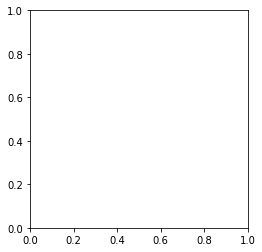

In [243]:
from skimage.io import imsave
test_path = q_imgs[10]
test_filename = test_path.split('/')[2].split('.')[0]
test = plt.imread(PATH + '/data/'+test_path)
#test = read_img(test_path, detector = 'ORB')
new_test = transform.rescale(test, 2)
plt.imshow(new_test)
imsave(PATH + '/'+test_filename + '_rescaled.jpg' ,new_test.astype(np.uint8))


In [229]:
test_path = q_imgs[10]
test_filename = test_path.split('/')[2].split('.')[0]
test = plt.imread(PATH + '/data/'+test_path)
new_test = adjust_gamma(test, 2)
new_test = adjust_log(new_test,0.5)
plt.imsave(PATH + '/'+test_filename + '_dark.jpg' ,new_test)

In [187]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [193]:
def img_transform(img,distortion,detector,q_img = None):
  if distortion.startswith('rotation'):
    angle = int(distortion.split('-')[1])
    path = PATH + '/data/query_rotated/' + q_img.split('/')[2]
    if os.path.isfile(path):
      transformed_img = read_img(path, detector)
    elif detector == 'SIFT':
      transformed_img = rotate_image(img, angle)
      cv2.imwrite( path ,transformed_img)
      transformed_img = read_img(path, detector)
    else:
      transformed_img = transform.rotate(img, angle)
  if distortion.startswith('rescale'):
    size = float(distortion.split('-')[1])
    path = PATH + '/data/query_rescaled/' + q_img.split('/')[2]
    if os.path.isfile(path):
      transformed_img = read_img(path, detector)
    elif detector == 'SIFT':
      new_img = read_img(q_img, detector = 'ORB')
      transformed_img = transform.rescale(new_img, size)
      plt.imsave(path ,transformed_img, cmap = plt.cm.gray)
      transformed_img = read_img(path, detector)
    else:
      transformed_img = transform.rescale(img, size)
  if distortion == 'dark':
    path = PATH + '/data/query_dark/' + q_img.split('/')[2]
    if os.path.isfile(path):
      transformed_img = read_img(path)
    else:
      transformed_img = adjust_gamma(img, 2)
      transformed_img = adjust_log(img, 0.5)
      plt.imsave(path ,transformed_img, cmap = plt.cm.gray)
  if distortion == 'blur':
    transformed_img = cv2.GaussianBlur(img, (5,5), 10.0)

  return transformed_img

In [191]:
distortions = ['rotation-25']
result_note = ''
def run():
  for distortion in distortions:
    result_path = get_filename('results',version=VERSION,detector=detector,descriptor_param = descriptor_param, result_note = distortion + result_note, attempt= attempt)
    
    total_ap = 0
    n_queries = len(q_imgs)

    for i in tqdm(range(n_queries)):
      
      start = timer()
      q_gimg = read_img(q_imgs[i], detector)
      end = timer()
      time1 = end - start
      if distortion != 'normal':
        q_img = img_transform(q_gimg,distortion,detector,q_img = q_imgs[i])
      else:
        q_img = q_gimg
      
      start = timer()
      query_bow = get_query_bow(detector, descriptor_extractor, centroids, q_img, map_bows)
      
      # Retrieve the indices of similar images from the map
      retrieved_imgs = retrieve(map_bows, query_bow)
      end = timer()
      time2 = end - start
      

      # Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)

      # relevant_imgs = np.where(sim[i, :] == 1)[0]
      # ap = average_precision(relevant_imgs, retrieved_imgs)
      '''
      result = [
        str(i),
        ','.join(list(map(str,retrieved_imgs))),
        ','.join(list(map(str,relevant_imgs))),
        str(ap)
      ]
      '''
      result = [
        str(i),
        ','.join(list(map(str,retrieved_imgs))),
        str(time1+time2)
      ]
      with open(result_path, 'a') as f:
        f.write(' '.join(result)+'\n')
      
      #total_ap += ap
    f.close()
    #map = total_ap / n_queries

In [192]:
run()

100%|██████████| 500/500 [01:02<00:00,  8.05it/s]


In [44]:
distortion = 'rotation-25'
result_note = ''
result_path = get_filename('results',version=VERSION,detector=detector,descriptor_param = descriptor_param, result_note = distortion + result_note, attempt= attempt)

total_ap = 0
n_queries = len(q_imgs)

for i in tqdm(range(n_queries)):
  
  start = timer()
  q_gimg = read_img(q_imgs[i], detector)
  end = timer()
  time1 = end - start
  if distortion != 'normal':
    q_img = img_transform(q_gimg,distortion,detector,q_img = q_imgs[i])
  else:
    q_img = q_gimg
  
  start = timer()
  query_bow = get_query_bow(detector, descriptor_extractor, centroids, q_img, map_bows)
  
  # Retrieve the indices of similar images from the map
  retrieved_imgs = retrieve(map_bows, query_bow)
  end = timer()
  time2 = end - start
  

  # Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)

  # relevant_imgs = np.where(sim[i, :] == 1)[0]
  # ap = average_precision(relevant_imgs, retrieved_imgs)
  '''
  result = [
    str(i),
    ','.join(list(map(str,retrieved_imgs))),
    ','.join(list(map(str,relevant_imgs))),
    str(ap)
  ]
  '''
  result = [
    str(i),
    ','.join(list(map(str,retrieved_imgs))),
    str(time1+time2)
  ]
  with open(result_path, 'a') as f:
    f.write(' '.join(result)+'\n')
  
  #total_ap += ap
f.close()
#map = total_ap / n_queries

  0%|          | 0/500 [00:00<?, ?it/s]


error: ignored

'\ncv2.imwrite(PATH + \'/data/test.jpg\',test_img)\ntest2 = cv2.imread(PATH + \'/data/test.jpg\')\nplt.imshow(test2,cmap="gray")\n'

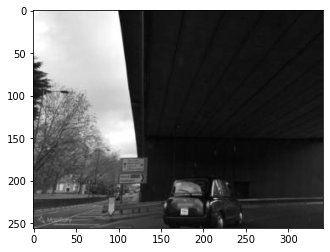

In [154]:
test_img = read_img(q_imgs[5],detector='ORB')
test_img = transform.rescale(test_img, 25)
plt.imshow(test_img,cmap="gray")
cv2.imwrite(PATH + '/data/test.jpg',test_img)
'''
cv2.imwrite(PATH + '/data/test.jpg',test_img)
test2 = cv2.imread(PATH + '/data/test.jpg')
plt.imshow(test2,cmap="gray")
'''

In [87]:
k, d = descriptor_extractor.detectAndCompute(test2,None)

In [92]:
q_imgs[2].split('/')[2]

'OYVwIomgOmQU3Q5hr-o0NQ.jpg'